# A/B Тестирование. Эффективность рекламы


Цель этого анализа - проверить, можно ли атрибутировать результаты продаж рекламе. Или же есть основания полагать, что не реклама, а другие факторы влияют на успех/провал кампании. Отличаются ли значимо коэффициенты конверсии группы, которой показывали рекламу и другой (контрольной) групп?


---


### Какие данные содержатся в таблице? 

* **User id**.

* **Test group**. У нас есть данные по двум группам людей - кому показали рекламу (ad) и кому показали просто публичное объявление (psa).

* **Converted**. True or False - приобрел ли участник эксперимента товар или нет. Для каждой группы можно высчитать процент конвертации.

* **Total ads**. Сколько раз человек видел рекламу/объявление.

* **Most ads day**. В какой день человек видел наибольшее число рекламы/объявлений.

* **Most ads hour**. В какой час человек видел наибольшее число рекламы/объявлений.


### План 

1. Импорт библиотек и файлов.
2. Просмотр и чистка данных.
3. Исследовательский анализ данных. Оценка качества данных для теста.
4. Тест
   * Выбор теста. 
   * Проверка условий. 
   * Тест.
   * Оценка теста. Мощность. Практическая значимость.
   * Визуализация
5. Итог

## **1. Импорт библиотек и файлов**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats import power
from statsmodels.stats.proportion import proportions_ztest
sns.set()

In [2]:
df = pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


## **2. Просмотр и чистка данных**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [4]:
#1. удалить первую колонку, дублирующую индекс

df = df.drop(columns = ['Unnamed: 0'])



In [5]:
#2. поменять названия колонок, убрать пробелы

df.columns = df.columns.str.replace(' ', '_')
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [6]:
#3. дубликаты

df[df.duplicated()]

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour


In [7]:
#4. пропущенные значения

df.isna().sum()

user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64

In [8]:
#5. проверить адекватность содержания числовых коколонок

df.total_ads.describe()

count    588101.000000
mean         24.820876
std          43.715181
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000
Name: total_ads, dtype: float64

Text(0.5, 1.0, 'Распределение числа показов рекламы/объявлений')

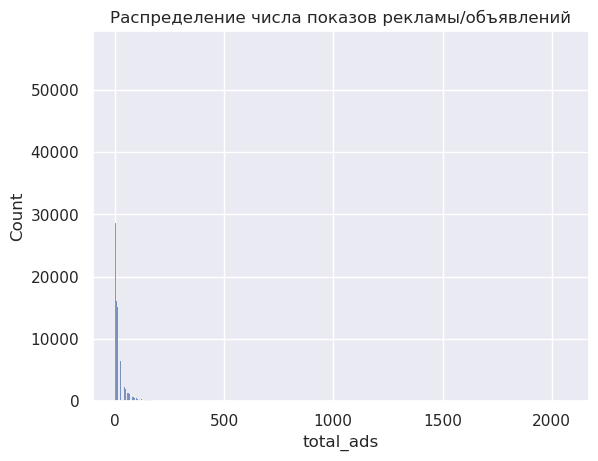

In [9]:
sns.histplot(df.total_ads)
plt.title('Распределение числа показов рекламы/объявлений')

Странно, что кому-то показывались объявления/реклама 2000 раз в день...
Скорее всего, это ошибка.

In [10]:
# проверить выбросы
df[df.total_ads > df.total_ads.quantile(q=0.99)].groupby('test_group')['total_ads'].agg(['mean', min, max])

,mean,min,max
test_group,,,
ad,327.390288,203,2065
psa,306.180000,203,907


In [11]:
# убрать выбросы, оставив 99% данных

df2 = df[df.total_ads < df.total_ads.quantile(q=0.99)]
df2.total_ads.describe()

count    582216.000000
mean         21.787785
std          28.035705
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max         201.000000
Name: total_ads, dtype: float64

Text(0.5, 1.0, 'Распределение числа показов рекламы/объявлений')

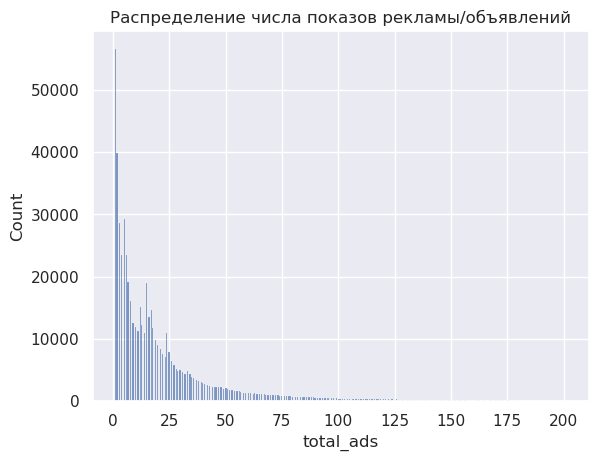

In [12]:
sns.histplot(df2.total_ads)
plt.title('Распределение числа показов рекламы/объявлений')

In [13]:
#6. проверить адекватность содержания категориальных коколонок
     #NB условно считаать час дня  категорией

for col in ['test_group', 'converted', 'most_ads_day', 'most_ads_hour']:
    print(col, 'distribution')
    print(df2[col].value_counts())
    print()

test_group distribution
ad     558946
psa     23270
Name: test_group, dtype: int64

converted distribution
False    568292
True      13924
Name: converted, dtype: int64

most_ads_day distribution
Friday       91396
Monday       86035
Sunday       84706
Thursday     82185
Saturday     80924
Wednesday    80089
Tuesday      76881
Name: most_ads_day, dtype: int64

most_ads_hour distribution
13    47164
12    46729
11    45691
14    45226
15    44168
10    38492
16    37334
17    34675
18    31963
9     30728
19    30010
21    29681
20    28609
22    26264
23    20099
8     17441
7      6290
0      5491
2      5284
1      4764
3      2662
6      2001
5       737
4       713
Name: most_ads_hour, dtype: int64



## **3. Исследовательский анализ данных**

In [14]:
# 1. проверить конверсию

df2.converted.value_counts(normalize=True)

False    0.976084
True     0.023916
Name: converted, dtype: float64

Коэффициент конверсии - около 2,4 %.

In [15]:
# 2. проверить конверсию по группам

df2.groupby('test_group')['converted'].mean()

test_group
ad     0.024231
psa    0.016330
Name: converted, dtype: float64

Text(0, 0.5, 'Коэффициент конверсии')

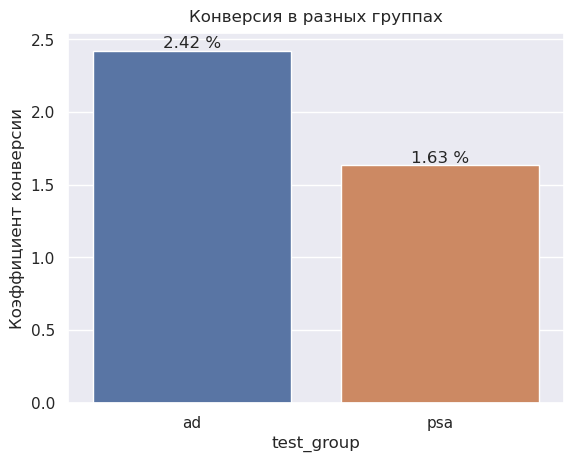

In [16]:
ax = sns.barplot(x=df2.groupby('test_group')['converted'].mean().index,
            y=df2.groupby('test_group')['converted'].mean()*100)

rects = ax.patches
labels = [str(i) + ' %' for i in round(df2.groupby('test_group')['converted'].mean()*100, 2)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
    )
plt.title('Конверсия в разных группах', va='bottom' )
plt.ylabel('Коэффициент конверсии')

Оценить размер эффекта - расчитать **Cohen's h**.

In [17]:
test = df2.test_group == 'ad'
control = df2.test_group == 'psa'

n_control = len(df2[control])
n_test = len(df2[test])
p_control = round(df2[control]['converted'].mean(),4)
p_test = round(df2[test]['converted'].mean(),4)
print("Размер контрольной группы -", n_control)
print("Размер тестовой группы -", n_test)
print("Пропорция (конверсия) контрольной группы -", p_control)
print("Пропорция (конверсия) тестовой группы -", p_test)

Размер контрольной группы - 23270
Размер тестовой группы - 558946
Пропорция (конверсия) контрольной группы - 0.0163
Пропорция (конверсия) тестовой группы - 0.0242


In [18]:
# 3. размер эффекта

from statsmodels.stats.proportion import proportion_effectsize
effect_size = proportion_effectsize(p_control, p_test)

delta_p = p_test - p_control
print('Абсолютная разница в пропорциях: ', abs(round((delta_p)*100,2)), '%')
print('Размер эффекта:', abs(round(effect_size,2)))

if effect_size > 0.8:
  print('Размер эффекта большой')
elif effect_size > 0.5:
  print('Размер эффекта средний')
elif effect_size > 0.2:
  print('Размер эффекта маленький')
else:
  print('Размер эффекта очень маленький')



Абсолютная разница в пропорциях:  0.79 %
Размер эффекта: 0.06
Размер эффекта очень маленький


Важно проверить **качество обеих групп**. Нет ли критических различий между группами, которые бы могли влиять на результаты эксперимента, мешая понять обособленную роль рекламы.

In [19]:
# 4. проверить число показа рекламы/объявлений по группам

df2.groupby('test_group')['total_ads'].mean()

test_group
ad     21.791137
psa    21.707263
Name: total_ads, dtype: float64

<Axes: xlabel='total_ads', ylabel='test_group'>

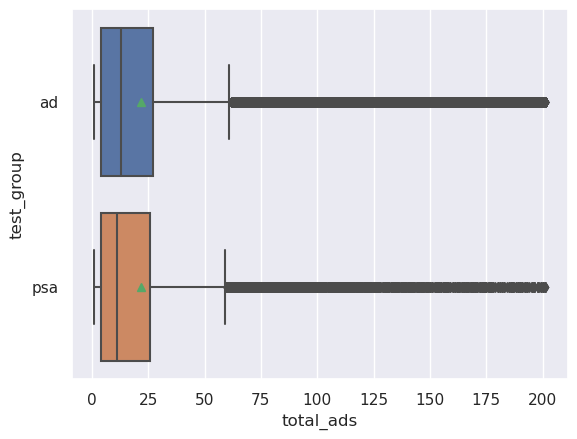

In [20]:
sns.boxplot(data=df2, y='test_group', x='total_ads', showmeans=True)

Можно считать различия несущественными.


---



Колонки с днями и часаами показывают, в какой день/час каждому человку показывалось самое большое количество объявлений.

In [21]:
# 5. проверить время показа (дни)
# Распределение по дням и группам (%)

round(pd.crosstab(df.test_group, df.most_ads_day, normalize='index') * 100, 2)

most_ads_day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
test_group,,,,,,,
ad,15.73,14.80,13.96,14.58,14.01,13.21,13.71
psa,16.17,14.89,12.15,13.00,16.60,12.36,14.84


In [22]:
# 6. проверить время показа (часы)

# Распределение по часам и группам (%)

round(pd.crosstab(df.test_group, df.most_ads_hour, normalize='index') * 100, 2)

most_ads_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
test_group,,,,,,,,,,,,,,,,,,,,,
ad,0.94,0.82,0.91,0.46,0.12,0.13,0.35,1.09,3.01,5.28,...,7.75,7.59,6.37,5.95,5.5,5.17,4.93,5.12,4.52,3.46
psa,0.96,0.79,0.77,0.38,0.12,0.10,0.35,1.01,2.80,5.11,...,7.95,7.77,6.82,5.88,5.4,5.03,4.58,4.60,3.90,2.63


Можно считать, что обе группы приципиально не отличаются по времени показа рекламы ил объявлений.

## **4. Тест**

1. Условия нормальности для валидного Z теста двух пропорций
2. Размеры выборок, достаточность размеров
3. Гипотеза и Тест
4. Мощность эксперимента
5. Визуализация эксперимента

### (1) Условия для валидного теста

In [23]:
#в каждой группе каждого исхода должно быть более 10

cond1 = (n_control)*p_control > 10
cond2 = (n_control)*(1 - p_control) > 10
cond3 = (n_test)*p_test > 10
cond4 = (n_test)*(1 - p_test) > 10

if cond1 & cond2 & cond3 & cond4:
  print('Мы можем аппроксимировать наши биномиальные распределения нормальными')
else:
  print('Мы НЕ можем аппроксимировать наши биномиальные распределения нормальными')

Мы можем аппроксимировать наши биномиальные распределения нормальными


### (2) Размер выборок

In [24]:
# 1. Размеры выборок. Еще раз посмотрим на группы

df2.test_group.value_counts()

ad     558946
psa     23270
Name: test_group, dtype: int64

In [25]:
# 2. Какого размера выборок было бы достаточно?
alpha = 0.05
beta = 0.2 #желаемая

sample_size = power.TTestIndPower().solve_power(effect_size=effect_size, alpha=alpha, power=1-beta, nobs1= None)
print(round(sample_size))

4944


/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


Наш размер превосходит достаточный для определение данного эффекта. В очень много раз. Это значит, что есть большой шанс получить разницу, которая **статистичски значимая, но практически - незначимая**.

### (3) Гипотеза

Двусторонний тест:

*   Нулевая гипотеза **Hₒ: p2 - p1 = 0** .
*   Альтернативная гипотеза **Hₐ: p2 - p1  ≠ 0**


---
* alpha = 0.05

In [26]:
test = df2[df2.test_group == 'ad']['converted'].sum() 
control = df2[df2.test_group == 'psa']['converted'].sum()

z_stat, p_value = proportions_ztest([control, test], nobs=[n_control, n_test] ,
                                  alternative='two-sided')
print('z =', z_stat)
print('p-value =', p_value)

z = -7.729563914889429
p-value = 1.0791561749201039e-14


### (4) Мощность эксперимента

In [27]:
# Мощность
# Вероятность отклонить нулевую гипотезу, когда она действительно неверна

ratio = n_test/n_control

test_power = power.TTestIndPower().solve_power(effect_size=effect_size, alpha=0.05, 
                                                power=None, nobs1= n_control, ratio=ratio)
print(round(test_power))

1


### (5) Визуализация аппроксимации разницы пропорций

In [28]:
# Визуализация

p_pooled = round((n_control * p_control + n_test * p_test)/(n_control + n_test),3)
se = round(np.sqrt(p_pooled*(1 - p_pooled) * (1/n_control + 1/n_test)),3)
mu_delta = 0
cutoff_left = round(norm.ppf(alpha/2, loc=mu_delta, scale=se),3)
cutoff_right = round(norm.ppf(1 - alpha/2, loc=mu_delta, scale=se),3)
delta = p_test - p_control

print('Общая объединенная доля =', p_pooled)
print('Общая объединенная стандартная ошибка =', se)
print('Критические значения = ', cutoff_left, 'и', cutoff_right)
print('Наблюдаемая разница =', delta)

Общая объединенная доля = 0.024
Общая объединенная стандартная ошибка = 0.001
Критические значения =  -0.002 и 0.002
Наблюдаемая разница = 0.0079


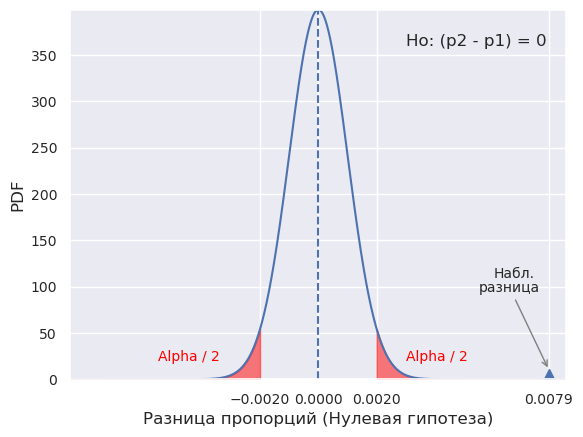

In [29]:
# График распределения
fig, ax = plt.subplots()


x = np.linspace( mu_delta - 8.5*se, mu_delta + 8.5*se, 1000)
y = norm.pdf(x, loc=mu_delta, scale= se)
sns.lineplot(x=x, y=y, ax=ax)

#mu delta
ax.axvline(mu_delta, linestyle='--')

#x ticks
plt.xticks([delta, cutoff_left, mu_delta, cutoff_right])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(delta, 0, "b^", markersize=15)
plt.text(0.0060, 110, 'Набл.', fontsize=10)
plt.annotate("разница", xy=(0.0079, 10), xytext=(0.0055, 95), 
            arrowprops={"arrowstyle":"->", "color":"gray"},
             fontsize=10)

#alpha
alpha_x = np.linspace(cutoff_right, mu_delta + 8.5 * se, 1000)
alpha_y = norm.pdf(alpha_x, loc = mu_delta, scale= se)
plt.fill_between(alpha_x, alpha_y, color='red', alpha=0.5)

alpha_x2 = np.linspace(mu_delta - 8.5 * se, cutoff_left, 1000)
alpha_y2 = norm.pdf(alpha_x2, loc = mu_delta, scale= se)
plt.fill_between(alpha_x2, alpha_y2, color='red', alpha=0.5)

plt.text(-0.0055, 20, 'Alpha / 2', color='red', fontsize=10)
plt.text(0.003, 20, 'Alpha / 2', color='red', fontsize=10)

#H null
plt.text(0.003, 360, 'Ho: (p2 - p1) = 0')

#labels
plt.xlabel('Разница пропорций (Нулевая гипотеза)')
plt.ylabel('PDF')

plt.autoscale(enable=True, axis='both', tight=True) 


## **5.  Итог**

* Тест показал статистически значимую разницу. Коэффициент конверсии у тех, кому показывали рекламу отличается от коэффициента конверсии тех, кто просто видел публичное объявление.

* Однако нужно учитывать, что такая разница, такая высокая Z статистика (более 7) и такая низкая стандратная ошибка (0.001) во многом были достигнуты за счет очень большого размера выборок (n).

* Это значит, что, вполне вероятно, статистически значимая разница в 0.79 % на практике не будет иметь значения.